In [1]:
################################################################################
##############    Classification: Logistic Regression - kNN    #################
################################################################################
### Load necessary modules -------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.metrics as mtrs
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
# Multicolor line
import matplotlib.collections 

from sklearn.calibration import calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn import preprocessing
import math
import ClassificationTools as CT
from statsmodels.stats import contingency_tables as cont_tab
from scipy.stats import binom_test
import warnings

In [2]:
### Load file --------------------------------------------
df = pd.read_csv('Simdata.dat', sep = "\t")
df.head()

X1        X2    Y
0 -3.745291  3.729409   NO
1  5.806532 -4.703332  YES
2  4.209833 -0.493488  YES
3  3.429156 -2.307669   NO
4 -0.195014  2.680303   NO

In [3]:
### Convert output variable to factor
df.Y = df.Y.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   X1      1000 non-null   float64 
 1   X2      1000 non-null   float64 
 2   Y       1000 non-null   category
dtypes: category(1), float64(2)
memory usage: 16.8 KB


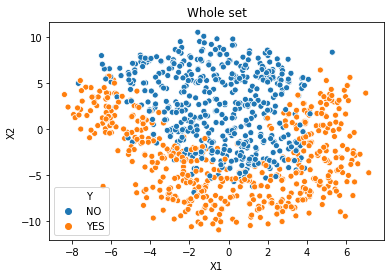

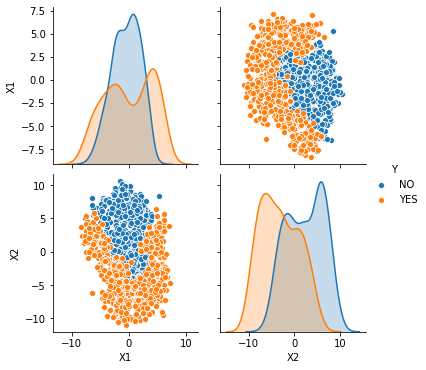

In [4]:
### Exploratory analysis -------------------------------------------------------------------------------------
sns.scatterplot(x = 'X1', y = 'X2', hue = 'Y', data = df).set_title("Whole set")
plt.show()
sns.pairplot(df, hue = 'Y')
plt.show()

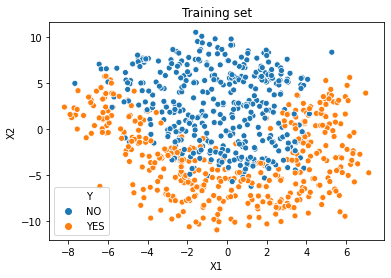

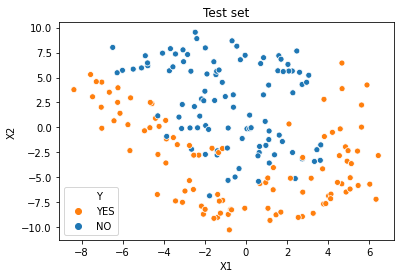

In [5]:
X = df[['X1','X2']]
y = df['Y']
## Divide the data into training and test sets ---------------------------------------------------
## Create random 80/20 % split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5, stratify = y)

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Y'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test

## plot training and test sets. 
## Try changing the value inside set.seed(). How does it affect the selected data?
palette = {'NO':'C0', 'YES':'C1'} # Needed to maintain color palette 
sns.scatterplot(x = 'X1', y = 'X2', hue = 'Y', data = dfTR_eval, palette=palette).set_title("Training set")
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x = 'X1', y = 'X2', hue = 'Y', data = dfTS_eval, palette=palette).set_title("Test set")
plt.show()



Resample 1: Accuracy - 0.76
Resample 2: Accuracy - 0.66
Resample 3: Accuracy - 0.70
Resample 4: Accuracy - 0.70
Resample 5: Accuracy - 0.74
Resample 6: Accuracy - 0.55
Resample 7: Accuracy - 0.75
Resample 8: Accuracy - 0.65
Resample 9: Accuracy - 0.78
Resample 10: Accuracy - 0.70
Mean accuracy - 0.70 (+/- 0.13)


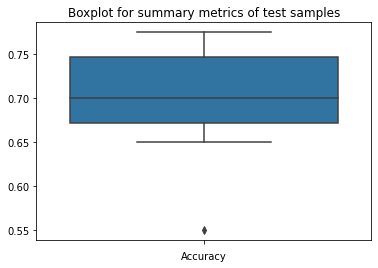

In [6]:
#-------------------------------------------------------------------------------------------------
#---------------------------- LOGISTIC REGRESSION MODEL ------------------------------------------
#-------------------------------------------------------------------------------------------------
## Train model -----------------------------------------------------------------------------------
pipe = Pipeline(steps=[('scaler',StandardScaler()), # Preprocess the variables when training the model 
                           ('LogReg',LogisticRegression(random_state=5))]) # Model to use in the pipeline
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
LogReg_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
LogReg_fit.fit(X_train, y_train) # Train both the scaler and the model

scores = cross_val_score(LogReg_fit, X_train, y_train, cv = 10) # Cross validation scores
for i in range(0,len(scores)):
    print("Resample %i: Accuracy - %0.2f" % (i+1, scores[i]) )
print("Mean accuracy - %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
ax = sns.boxplot(y = scores).set_title('Boxplot for summary metrics of test samples')
plt.xlabel('Accuracy')
plt.show()

In [7]:
CT.summaryLogReg(LogReg_fit.best_estimator_['LogReg'], X_train, y_train)

Deviance Residuals:
        Min        1Q        Median        3Q       Max
0 -0.999888 -0.020847 -4.414411e-08  0.007797  0.999838

Coefficients:
           Estimate  Std. Err    t-value  Pr(>|t|) Signif
Intercept -0.001520  0.172088  -0.008833  0.992952       
X1        -0.060314  0.045544  -1.324296  0.185405       
X2        -1.480518  0.134742 -10.987795  0.000000    ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
AIC: 6.000000180554587  (no es fiable, revisar formula de AIC)


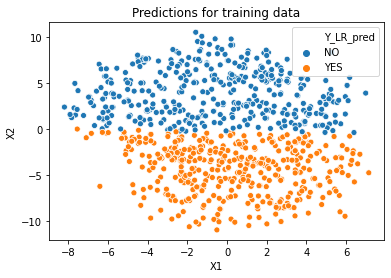

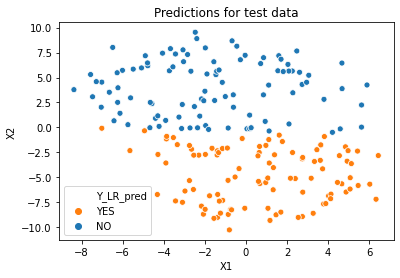

In [8]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_pred'] = LogReg_fit.predict(X_train)
dfTR_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_train)[:,0]
dfTR_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_train)[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LR_pred'] = LogReg_fit.predict(X_test)
dfTS_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_test)[:,0]
dfTS_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_test)[:,1]

### Plot predictions of the model
palette = {'NO':'C0', 'YES':'C1'} # Needed to maintain color palette 
sns.scatterplot(x='X1', y='X2', hue='Y_LR_pred', data=dfTR_eval, palette=palette).set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='X1', y='X2', hue='Y_LR_pred', data=dfTS_eval, palette=palette).set_title('Predictions for test data')
plt.show()

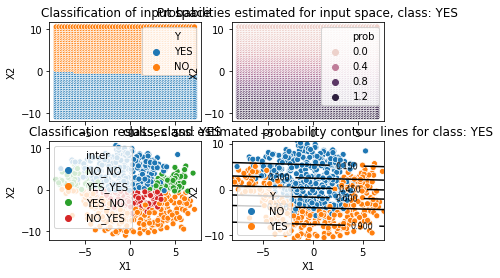

In [9]:
### Plot classification in a 2 dimensional space
CT.plot2DClass(X_train, dfTR_eval['Y'], LogReg_fit, 'X1', 'X2', 'YES', 50) 

In [10]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_LR_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO  275  125
      YES  116  284

Accuracy: 0.7
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.4
Mcnemar's Test P-Value: 0.61
Sensitivity: 0.71
Specificity: 0.69
Pos pred value: 0.69
Neg pred value: 0.7
Prevalence: 0.5
Detection Rate: 0.36
Detection prevalence: 0.51
Balanced accuracy: 0.7
F Score: 0.7
Positive class: YES


In [11]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_LR_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference  YES  NO
      YES   72  28
       NO   29  71

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.43
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.71
Specificity: 0.72
Pos pred value: 0.72
Neg pred value: 0.71
Prevalence: 0.5
Detection Rate: 0.36
Detection prevalence: 0.5
Balanced accuracy: 0.72
F Score: 0.71
Positive class: NO


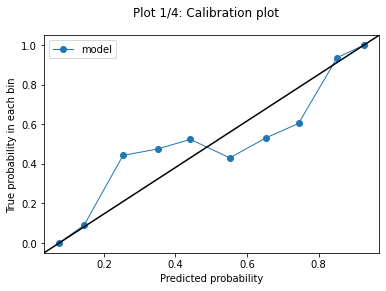

No handles with labels found to put in legend.


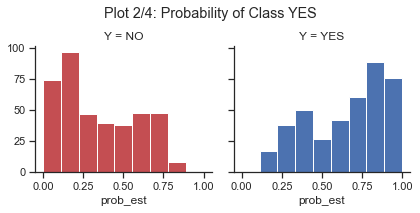

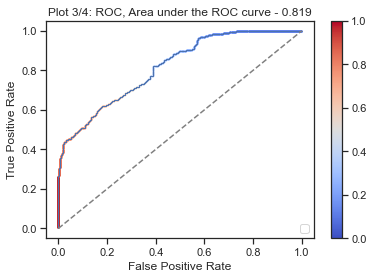

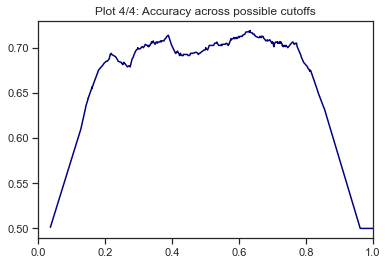

In [12]:
CT.plotClassPerformance(dfTR_eval['Y'], LogReg_fit.predict_proba(X_train), selClass='YES')

Resample 1: Accuracy - 0.82
Resample 2: Accuracy - 0.88
Resample 3: Accuracy - 0.85
Resample 4: Accuracy - 0.82
Resample 5: Accuracy - 0.89
Resample 6: Accuracy - 0.85
Resample 7: Accuracy - 0.91
Resample 8: Accuracy - 0.86
Resample 9: Accuracy - 0.91
Resample 10: Accuracy - 0.89
Mean accuracy - 0.87 (+/- 0.06)


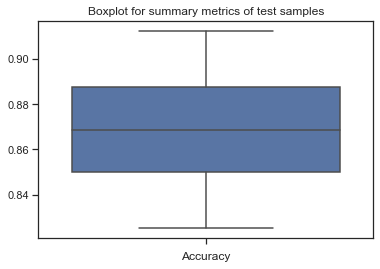

In [13]:
## Include X1 squared
df['X1sq'] = df['X1'] ** 2
X = df[['X1','X2','X1sq']]
y = df['Y']
## Divide the data into training and test sets ---------------------------------------------------
## Create random 80/20 % split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5, stratify = y)
## Train model -----------------------------------------------------------------------------------
pipe = Pipeline(steps=[('scaler',StandardScaler()), # Preprocess the variables when training the model 
                       ('LogReg',LogisticRegression(random_state=5))]) # Model to use in the pipeline
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
param = {}
LogReg_fit_sq = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
LogReg_fit_sq.fit(X_train[['X1sq','X2']], y_train) # Train both the scaler and the model

scores_sq = cross_val_score(LogReg_fit_sq, X_train, y_train, cv = 10) # Cross-validation scores
for i in range(0,len(scores_sq)):
    print("Resample %i: Accuracy - %0.2f" % (i+1, scores_sq[i]) )
print("Mean accuracy - %0.2f (+/- %0.2f)" % (scores_sq.mean(), scores_sq.std() * 2))
ax = sns.boxplot(y = scores_sq).set_title('Boxplot for summary metrics of test samples')
plt.xlabel('Accuracy')
plt.show()

In [14]:
CT.summaryLogReg(LogReg_fit_sq.best_estimator_['LogReg'], X_train[['X1sq','X2']], y_train)

Deviance Residuals:
   Min        1Q        Median   3Q       Max
0 -1.0 -0.998634 -2.641040e-13  0.0  0.007704

Coefficients:
           Estimate  Std. Err   t-value  Pr(>|t|) Signif
Intercept -0.129466  0.536488 -0.241321  0.809306       
X1sq       2.519938  0.529611  4.758093  0.000002    ***
X2        -2.876041  0.591184 -4.864883  0.000001    ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
AIC: 6.0  (no es fiable, revisar formula de AIC)


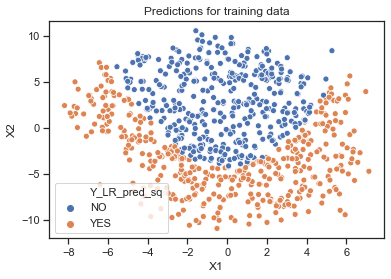

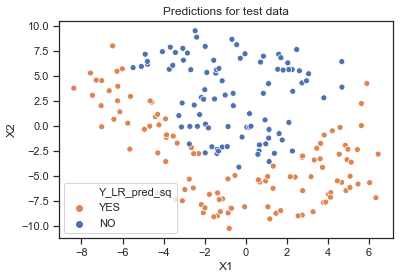

In [15]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_LR_pred_sq'] = LogReg_fit_sq.predict(X_train[['X1sq','X2']])
dfTR_eval['Y_LR_prob_neg_sq'] = LogReg_fit_sq.predict_proba(X_train[['X1sq','X2']])[:,0]
dfTR_eval['Y_LR_prob_pos_sq'] = LogReg_fit_sq.predict_proba(X_train[['X1sq','X2']])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_LR_pred_sq'] = LogReg_fit_sq.predict(X_test[['X1sq','X2']])
dfTS_eval['Y_LR_prob_neg_sq'] = LogReg_fit_sq.predict_proba(X_test[['X1sq','X2']])[:,0]
dfTS_eval['Y_LR_prob_pos_sq'] = LogReg_fit_sq.predict_proba(X_test[['X1sq','X2']])[:,1]

### Plot predictions of the model
palette = {'NO':'C0', 'YES':'C1'} # Needed to maintain color palette 
sns.scatterplot(x='X1', y='X2', hue='Y_LR_pred_sq', data=dfTR_eval, palette=palette).set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='X1', y='X2', hue='Y_LR_pred_sq', data=dfTS_eval, palette=palette).set_title('Predictions for test data')
plt.show()

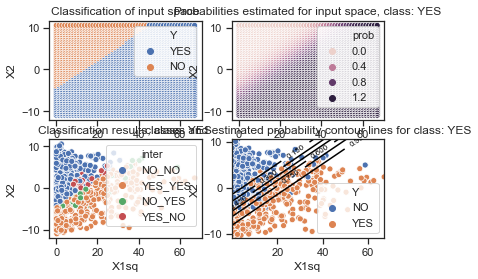

In [16]:
### Plot classification in a 2 dimensional space
CT.plot2DClass(X_train[['X1sq','X2']], dfTR_eval['Y'], LogReg_fit_sq, 'X1sq', 'X2', 'YES', 50) 

In [17]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_LR_pred_sq'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO  344   56
      YES   46  354

Accuracy: 0.87
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.74
Mcnemar's Test P-Value: 0.37
Sensitivity: 0.88
Specificity: 0.86
Pos pred value: 0.86
Neg pred value: 0.88
Prevalence: 0.5
Detection Rate: 0.44
Detection prevalence: 0.51
Balanced accuracy: 0.87
F Score: 0.87
Positive class: YES


In [18]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_LR_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference  YES  NO
      YES   72  28
       NO   29  71

Accuracy: 0.72
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.43
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.71
Specificity: 0.72
Pos pred value: 0.72
Neg pred value: 0.71
Prevalence: 0.5
Detection Rate: 0.36
Detection prevalence: 0.5
Balanced accuracy: 0.72
F Score: 0.71
Positive class: NO


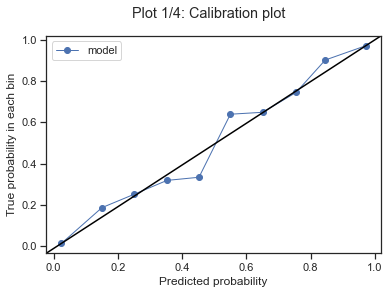

No handles with labels found to put in legend.


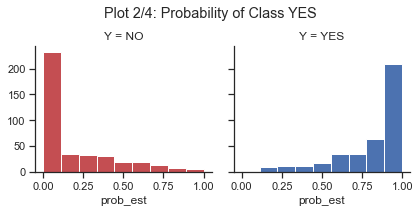

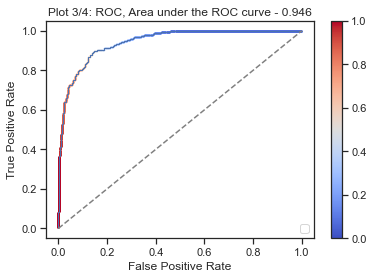

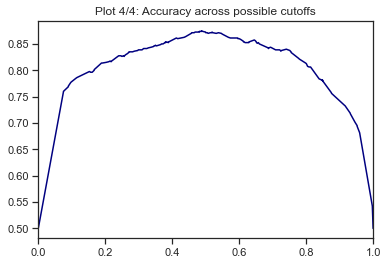

In [19]:
CT.plotClassPerformance(dfTR_eval['Y'], LogReg_fit_sq.predict_proba(X_train[['X1sq','X2']]), selClass='YES')

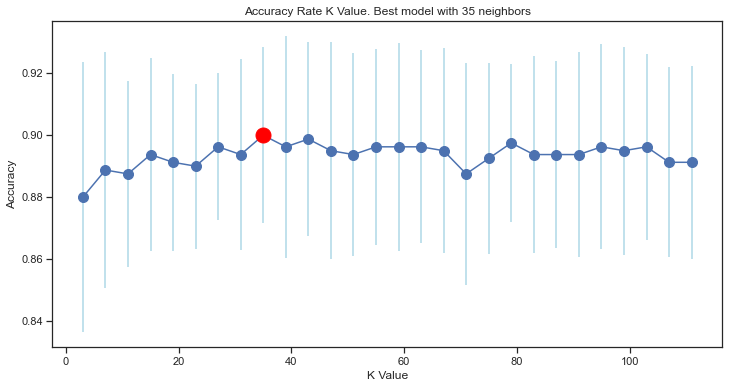

In [20]:
#-------------------------------------------------------------------------------------------------
#---------------------------------- KNN MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Train model -----------------------------------------------------------------------------------
param = {'knn__n_neighbors': range(3,115,4)} #Number of neighbors

pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
knn_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
knn_fit.fit(X_train[['X1','X2']], y_train) # Search in grid

# Plot the cross validation score (accuracy) in the Grid Search
nFolds = 10
cv_errors = np.empty([nFolds,len(knn_fit.cv_results_['split0_test_score'])])
for split in range(nFolds):
    cv_errors[split,:] = knn_fit.cv_results_['split' + str(split) + '_test_score']
meanAcc = cv_errors.mean(0)
stdAcc = cv_errors.std(0)

scores_knn = meanAcc # Store cv-scores for later

plt.figure(figsize=(12, 6))
plt.plot(knn_fit.cv_results_['param_knn__n_neighbors'], meanAcc, marker='o', markersize=10)
plt.errorbar(knn_fit.cv_results_['param_knn__n_neighbors'], meanAcc, yerr=stdAcc, linestyle="None", ecolor='lightblue')
plt.plot(knn_fit.best_params_['knn__n_neighbors'], knn_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate K Value. Best model with ' + str(knn_fit.best_params_['knn__n_neighbors']) + ' neighbors')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.show()

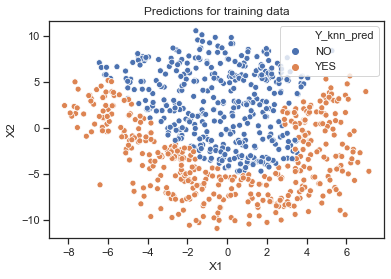

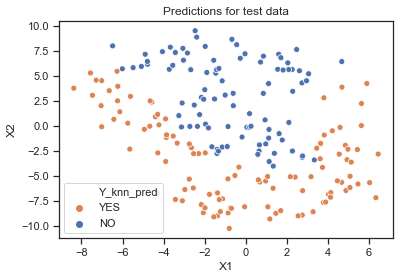

In [21]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_knn_pred'] = knn_fit.predict(X_train[['X1','X2']])
dfTR_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_train[['X1','X2']])[:,0]
dfTR_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_train[['X1','X2']])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_knn_pred'] = knn_fit.predict(X_test[['X1','X2']])
dfTS_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_test[['X1','X2']])[:,0]
dfTS_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_test[['X1','X2']])[:,1]

### Plot predictions of the model
palette = {'NO':'C0', 'YES':'C1'} # Needed to maintain color palette 
sns.scatterplot(x='X1', y='X2', hue='Y_knn_pred', data=dfTR_eval, palette=palette).set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='X1', y='X2', hue='Y_knn_pred', data=dfTS_eval, palette=palette).set_title('Predictions for test data')
plt.show()

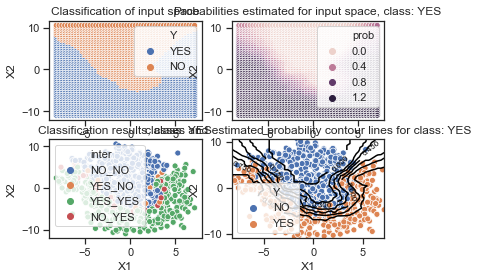

In [22]:
### Plot classification in a 2 dimensional space
CT.plot2DClass(X_train[['X1','X2']], dfTR_eval['Y'], knn_fit, 'X1', 'X2', 'YES', 50) 

In [23]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_knn_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference   NO  YES
       NO  357   43
      YES   37  363

Accuracy: 0.9
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.8
Mcnemar's Test P-Value: 0.58
Sensitivity: 0.91
Specificity: 0.89
Pos pred value: 0.89
Neg pred value: 0.91
Prevalence: 0.5
Detection Rate: 0.45
Detection prevalence: 0.51
Balanced accuracy: 0.9
F Score: 0.9
Positive class: YES


In [24]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_knn_pred'])

Confusion Matrix and Statistics
	   Prediction
Reference  YES  NO
      YES   93   7
       NO   15  85

Accuracy: 0.89
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.78
Mcnemar's Test P-Value: 0.13
Sensitivity: 0.85
Specificity: 0.93
Pos pred value: 0.92
Neg pred value: 0.86
Prevalence: 0.5
Detection Rate: 0.42
Detection prevalence: 0.46
Balanced accuracy: 0.89
F Score: 0.89
Positive class: NO


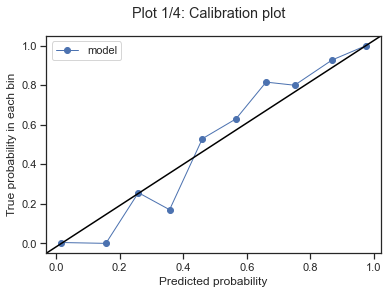

No handles with labels found to put in legend.


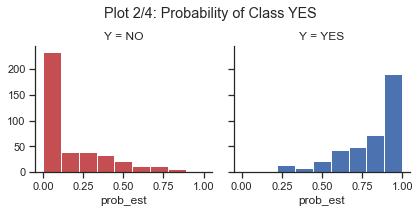

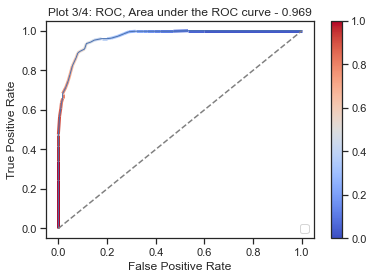

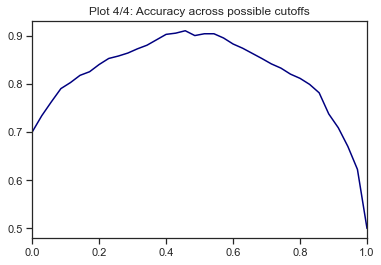

In [25]:
CT.plotClassPerformance(dfTR_eval['Y'], knn_fit.predict_proba(X_train[['X1','X2']]), selClass='YES')

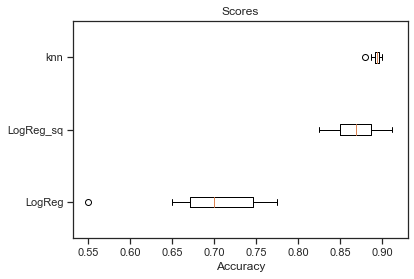

In [26]:
## Compare models
metric = 'Accuracy'
score = {'LogReg': scores, 'LogReg_sq': scores_sq, 'knn': scores_knn}
CT.dotplot(score, metric)


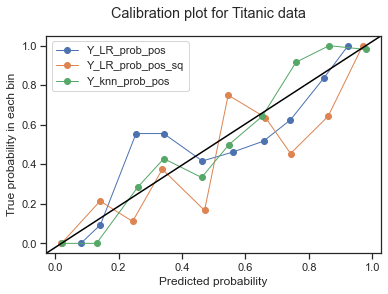

In [27]:
CT.calibration_plot(y_test, dfTS_eval[['Y_LR_prob_pos','Y_LR_prob_pos_sq','Y_knn_prob_pos']])

Area under the ROC curve of Y_LR_prob_pos : 0.825
Area under the ROC curve of Y_LR_prob_pos_sq : 0.951
Area under the ROC curve of Y_knn_prob_pos : 0.969


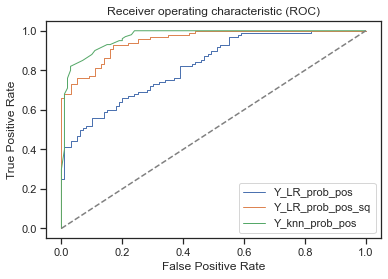

In [28]:
CT.roc_curve(y_test,dfTS_eval[['Y_LR_prob_pos','Y_LR_prob_pos_sq','Y_knn_prob_pos']], 'YES')